In [1]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import sklearn

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import torch.utils.data as data_utils
from torch.autograd import Variable

## Data - Sinusoid

In [2]:
np.random.seed(2)

def getdata(T=20,L=1000,N=100):
    x = np.empty((N, L), 'int64')
    x[:] = np.array(range(L)) + np.random.randint(-4 * T, 4 * T, N).reshape(N, 1)
    data = np.sin(x / 1.0 / T).astype('float64')
    return data

dim: (100, 1000)


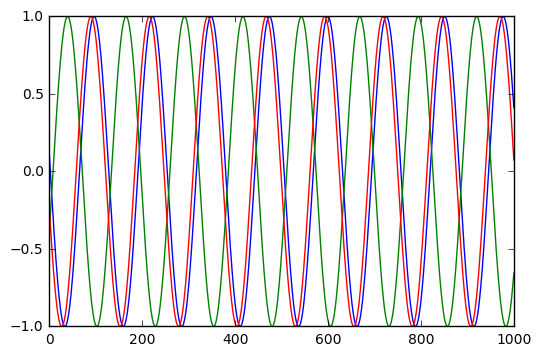

In [3]:
data = getdata()
print 'dim:', data.shape
for i in range(3):
    plt.plot(data[i])

In [4]:
class myLSTMCell(nn.Module):
    def __init__(self, input_size, hidden_size):
        super(myLSTMCell, self).__init__()

        self.input_size  = input_size
        self.hidden_size = hidden_size
        self.u_size      = input_size + hidden_size # concat x & h size
 
        # lstm weights
        self.weight_fx = nn.Linear(self.u_size, hidden_size)
        self.weight_ix = nn.Linear(self.u_size, hidden_size)
        self.weight_cx = nn.Linear(self.u_size, hidden_size)
        self.weight_ox = nn.Linear(self.u_size, hidden_size)

    def forward(self,x,state):
        h0, c0 = state   # retrieve previous cell & hidden states

        u = torch.cat((x,h0),1)  # Concatenation of input & previous state 

        f = F.sigmoid(self.weight_fx(u))  # forget gate
        i = F.sigmoid(self.weight_ix(u))  # input gate
        o = F.sigmoid(self.weight_ox(u))  # output gate
        g = F.tanh(self.weight_cx(u))     # candidate cell, c_tilda

        # Compute current states
        cx  = f * c0  +  i * g            # cell state
        hx  = o * F.tanh(cx)              # hidden state

        return hx, cx

In [5]:
class myGRUCell(nn.Module):
    def __init__(self, input_size, hidden_size):
        super(myGRUCell, self).__init__()

        self.input_size  = input_size
        self.hidden_size = hidden_size
        self.u_size      = input_size + hidden_size # concat x & h size
 
        # GRU weights
        self.weight_zx = nn.Linear(self.u_size, hidden_size) 
        self.weight_rx = nn.Linear(self.u_size, hidden_size)
        self.weight_hx = nn.Linear(self.u_size, hidden_size)


    def forward(self,x,state):
        u = torch.cat((x,state),1)  # Concatenation of input & previous state 

        z = F.sigmoid(self.weight_zx(u))  # update gate
        r = F.sigmoid(self.weight_rx(u))  # reset gate

        g = F.tanh(self.weight_hx(torch.cat((x,r*state),1))) # candidate cell state
        h = (1 - z)*state + z*g

        return h

In [16]:
class kGRUCell(nn.Module):
    def __init__(self, input_size, hidden_size):
        super(kGRUCell, self).__init__()

        self.input_size  = input_size
        self.hidden_size = hidden_size
        self.u_size      = input_size + hidden_size # concat x & h size
 
        # GRU weights
        self.weight_zx = nn.Linear(self.u_size, hidden_size) 
        self.weight_hx = nn.Linear(self.u_size, hidden_size)


    def forward(self,x,state):
        u = torch.cat((x,state),1)  # Concatenation of input & previous state 

        z = F.sigmoid(self.weight_zx(u))  # update gate
        g = F.tanh(self.weight_hx(u)) # candidate cell state
        h = (1 - z)*state + z*g

        return h

In [17]:
class Sequence(nn.Module):
    def __init__(self):
        super(Sequence, self).__init__() 
        self.gru1 = kGRUCell(1,51)
        self.gru2 = kGRUCell(51,51)
        self.linear = nn.Linear(51, 1)

    def forward(self, input, future = 0):
        outputs = []
        h_t1 = Variable(torch.zeros(input.size(0), 51).double(), requires_grad=False)
        h_t2 = Variable(torch.zeros(input.size(0), 51).double(), requires_grad=False)
 
        for i, input_t in enumerate(input.chunk(input.size(1), dim=1)):
            h_t1 = self.gru1(input_t, h_t1)
            h_t2 = self.gru2(h_t1, h_t2)
            output = self.linear(h_t2)
            outputs += [output]
            
        for i in range(future):# if we should predict the future
            h_t1 = self.gru1(output,h_t1)
            h_t2 = self.gru2(h_t1,h_t2)
            output = self.linear(h_t2)
            outputs += [output]
        outputs = torch.stack(outputs, 1).squeeze(2)
        return outputs

In [18]:
# class Sequence(nn.Module):
#     def __init__(self):
#         super(Sequence, self).__init__() 
#         self.lstm1 = myLSTMCell(1,51)
#         self.lstm2 = myLSTMCell(51,51)
#         self.linear = nn.Linear(51, 1)

#     def forward(self, input, future = 0):
#         outputs = []
#         h_t = Variable(torch.zeros(input.size(0), 51).double(), requires_grad=False)
#         c_t = Variable(torch.zeros(input.size(0), 51).double(), requires_grad=False)
#         h_t2 = Variable(torch.zeros(input.size(0), 51).double(), requires_grad=False)
#         c_t2 = Variable(torch.zeros(input.size(0), 51).double(), requires_grad=False)

#         for i, input_t in enumerate(input.chunk(input.size(1), dim=1)):
#             h_t, c_t = self.lstm1(input_t, (h_t, c_t))
#             h_t2, c_t2 = self.lstm2(h_t, (h_t2, c_t2))
#             output = self.linear(h_t2)
#             outputs += [output]
            
#         for i in range(future):# if we should predict the future
#             h_t, c_t = self.lstm1(output, (h_t, c_t))
#             h_t2, c_t2 = self.lstm2(h_t, (h_t2, c_t2))
#             output = self.linear(h_t2)
#             outputs += [output]
#         outputs = torch.stack(outputs, 1).squeeze(2)
#         return outputs

In [19]:
# set random seed to 0
np.random.seed(0)
torch.manual_seed(0)

#training set
input = Variable(torch.from_numpy(data[3:, :-1]), requires_grad=False)
target = Variable(torch.from_numpy(data[3:, 1:]), requires_grad=False)
test_input = Variable(torch.from_numpy(data[:3, :-1]), requires_grad=False)
test_target = Variable(torch.from_numpy(data[:3, 1:]), requires_grad=False)

# build the model
seq = Sequence()
seq.double()
criterion = nn.MSELoss()

# use LBFGS as optimizer since we can load the whole data to train
optimizer = optim.LBFGS(seq.parameters(), lr=0.8)

In [20]:
#begin to train
for i in range(15):
    print('STEP: ', i)
    
    def closure():
        optimizer.zero_grad()
        out = seq(input)
        loss = criterion(out, target)
        print('loss:', loss.data.numpy()[0])
        loss.backward()
        return loss
    
    optimizer.step(closure)

    # begin to predict
    future = 1000
    pred = seq(test_input, future = future)
    loss = criterion(pred[:, :-future], test_target)
    print('test loss:', loss.data.numpy()[0])
    y = pred.data.numpy()
    # draw the result
    plt.figure(figsize=(30,10))
    plt.title('Predict future values for time sequences\n(Dashlines are predicted values)', fontsize=30)
    plt.xlabel('x', fontsize=20)
    plt.ylabel('y', fontsize=20)
    plt.xticks(fontsize=20)
    plt.yticks(fontsize=20)
    def draw(yi, color):
        plt.plot(np.arange(input.size(1)), yi[:input.size(1)], color, linewidth = 2.0)
        plt.plot(np.arange(input.size(1), input.size(1) + future), yi[input.size(1):], color + ':', linewidth = 2.0)
    draw(y[0], 'r')
    draw(y[1], 'g')
    draw(y[2], 'b')
    plt.savefig('plots/predict%d.pdf'%i)
    plt.close()

('STEP: ', 0)
('loss:', 0.50687436096364491)
('loss:', 0.49345370707855957)
('loss:', 0.36724616572585822)
('loss:', 0.091925181716726395)
('loss:', 0.044011386521228012)
('loss:', 0.035773752256615408)
('loss:', 0.033108548132772579)
('loss:', 0.0093354552106994417)
('loss:', 0.0036207912224253585)
('loss:', 0.0023277071239504641)
('loss:', 0.0014712765968608028)
('loss:', 0.0011024706360263179)
('loss:', 0.0010766178542872078)
('loss:', 0.0010731631915040026)
('loss:', 0.0010702827216381907)
('loss:', 0.0010585680346425436)
('loss:', 0.0010366773968856077)
('loss:', 0.00099543725481316347)
('loss:', 0.00093645041411640536)
('loss:', 0.00085510285282321434)
('test loss:', 0.00033028982912960931)
('STEP: ', 1)
('loss:', 0.00073418930307697367)
('loss:', 0.00065363348826871532)
('loss:', 0.00061755737597339285)
('loss:', 0.00059287572400449576)
('loss:', 0.00058422799618637177)
('loss:', 0.00057831579995187409)
('loss:', 0.00057657531042761955)
('loss:', 0.0005751156063153578)
('loss:',